<a href="https://colab.research.google.com/github/c-labropoulos/NN-for-lithological-segmentation/blob/main/GEOIMAGESMENTATIOn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Google Drive Mounting

In [49]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Required External Libraries
The rasterio is required to fetch the image date from geotif file format.
The keras-unet-collection is a library to initiate U-Net image segmentation model  based on Tensorflow.



In [50]:
!pip install rasterio
!pip install keras-unet-collection

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Utilities

In [51]:
import os
import cv2 as cv
import numpy as np
import rasterio
import tensorflow as tf
import math

### Data Generator
Define a data generator class to fetch the data to the segmentation model during training.

In [52]:
class DataGen(tf.keras.utils.Sequence):
  # Data generator to fetch batches of RGB images and 18 layers masks
  # The class inherited must implement __len__, __getitem__ methods
  
  def __init__(self, x_set, batch_size):
    # x_set is a list of image path to training images 
    self.x = x_set
    # Number of images to feed per batch during training
    self.batch_size = batch_size

  def __len__(self):
    # Returns the number of images 
    return math.ceil(len(self.x) / self.batch_size)

  def __getitem__(self, idx):
    # Feed a batch of images (x) and label (y) to the model during traiing and validation. The images (x) and labels (y) are preprocessed here.

    low = idx * self.batch_size
    # Cap upper bound at array length; the last batch may be smaller
    # if the total number of items is not a multiple of batch size.
    high = min(low + self.batch_size, len(self.x))
    batch_x = self.x[low:high]

    # Placeholder for images (x) and labels (y)
    x=[] ; y=[]

    for tiff_path in batch_x:

      # Input RGB Image (x)

      # Open the tiff file
      tiff_file = rasterio.open(tiff_path) 
      # Read all layers
      tiff_img = tiff_file.read()
      # Get R, G, B components from layer 16, 15, 14 respectively. Make element with 'nan' to 0, scale to [0-255], equalize histogram to enhance contrast.
      # Rescale back to [0-1], expand the dimension on axis-2 (for example to make shape from (256, 256) to become (256, 256, 1))
      r = tiff_img[16] ; r[np.isnan(r)]=0 ; r = (r/r.max())*255 ; r=cv.equalizeHist(r.astype('uint8')) ; r = r/255 ; r = np.expand_dims(r, axis=2)
      g = tiff_img[15] ; g[np.isnan(g)]=0 ; g = (g/g.max())*255 ; g=cv.equalizeHist(g.astype('uint8')) ; g = g/255 ; g = np.expand_dims(g, axis=2)
      b = tiff_img[14] ; b[np.isnan(b)]=0 ; b = (b/b.max())*255 ; b=cv.equalizeHist(b.astype('uint8')) ; b = b/255 ; b = np.expand_dims(b, axis=2)
      # Concat R, G, B array in depth axes 
      rgb_img = np.concatenate([r, g, b], 2)
      # Resize the array WxH to 256x256 to match the input size of U-Net
      rgb_img = cv.resize(rgb_img, (256,256))
      x.append(rgb_img)

      # Mask Label (y)

      # Hot encode the label from 1 layer array to 18 layer array
      mask = self.__hot_encode_label(tiff_path, n_class=18)
      # Resize the array WxH to 256x256 to match the output size of U-Net
      mask = cv.resize(mask, (256,256))
      y.append(mask)

    # Make x and y as numpy array
    x = np.asarray(x)
    y = np.asarray(y)

    # Return array of images and labels. The number of images in x and number of labels in y depends on the batch size
    return x, y

  def __hot_encode_label(self, tiff_path, n_class, label_channel=25):
    # Open tiff file
    tiff_file = rasterio.open(tiff_path) 
    # Extract mask from layer 25
    mask = tiff_file.read(label_channel)
    # Make element with value -999 to 16
    mask[mask==-999] = 16
    # Make element with value -100 to 17
    mask[mask==-100] = 17
    encoded = np.zeros((mask.shape[0], mask.shape[1], n_class))
    for i in range(n_class):
      encoded[:,:,i] = mask==i

    return encoded


class DataGenSingle(tf.keras.utils.Sequence):
  # Data generator to fetch batches of RGB images and 1 specific layer of masks
  # The class inherited must implement __len__, __getitem__ methods

  def __init__(self, x_set, batch_size, label_layer):
    # x_set is a list of image path to training images
    self.x = x_set
    # Number of images to feed per batch during training
    self.batch_size = batch_size
    # Chosen mask layer for training
    self.label_layer = label_layer

  def __len__(self):
    # Returns the number of images 
    return math.ceil(len(self.x) / self.batch_size)

  def __getitem__(self, idx):
    # Feed a batch of images (x) and label (y) to the model during traiing and validation. The images (x) and labels (y) are preprocessed here.

    low = idx * self.batch_size
    # Cap upper bound at array length; the last batch may be smaller
    # if the total number of items is not a multiple of batch size.
    high = min(low + self.batch_size, len(self.x))
    batch_x = self.x[low:high]

    # Placeholder for images (x) and labels (y)
    x=[] ; y=[]

    for tiff_path in batch_x:

      # Input RGB Image (x)

      # Open tiff file
      tiff_file = rasterio.open(tiff_path) 
      # Read all layers
      tiff_img = tiff_file.read()
      # Get R, G, B components from layer 16, 15, 14 respectively. Make element with 'nan' to 0, scale to [0-255], equalize histogram to enhance contrast.
      # Rescale back to [0-1], expand the dimension on axis-2 (for example to make shape from (256, 256) to become (256, 256, 1))
      r = tiff_img[16] ; r[np.isnan(r)]=0 ; r = (r/r.max())*255 ; r=cv.equalizeHist(r.astype('uint8')) ; r = r/255 ; r = np.expand_dims(r, axis=2)
      g = tiff_img[15] ; g[np.isnan(g)]=0 ; g = (g/g.max())*255 ; g=cv.equalizeHist(g.astype('uint8')) ; g = g/255 ; g = np.expand_dims(g, axis=2)
      b = tiff_img[14] ; b[np.isnan(b)]=0 ; b = (b/b.max())*255 ; b=cv.equalizeHist(b.astype('uint8')) ; b = b/255 ; b = np.expand_dims(b, axis=2)
      # Concat R, G, B array in depth axes 
      rgb_img = np.concatenate([r, g, b], 2)
      # Resize the array WxH to 256x256 to match the input size of U-Net
      rgb_img = cv.resize(rgb_img, (256,256))
      x.append(rgb_img)

      # Mask Label (y)

      # Hot encode the label from 1 layer array to 18 layer array and return array with 1 selected layer
      mask = self.__hot_encode_label(tiff_path, self.label_layer, n_class=18)
      # Resize the array WxH to 256x256 to match the output size of U-Net
      mask = cv.resize(mask, (256,256))
      y.append(mask)
    
    # Make x and y as numpy array
    x = np.asarray(x)
    y = np.asarray(y)

    return x, y

  def __hot_encode_label(self, tiff_path, label_layer, n_class=18, label_channel=25):
    # Open tiff file
    tiff_file = rasterio.open(tiff_path) 
    # Extract mask from layer 25
    mask = tiff_file.read(label_channel)
    # Make element with value -999 to 16
    mask[mask==-999] = 16
    # Make element with value -100 to 17
    mask[mask==-100] = 17
    encoded = np.zeros((mask.shape[0], mask.shape[1], n_class))
    for i in range(n_class):
      encoded[:,:,i] = mask==i

    return encoded[:,:,label_layer]
      


**Class `DataGen`:** 

The `DataGen` class is a custom data generator that prepares batches of RGB images and their corresponding masks for a neural network, such as a U-Net for image segmentation tasks. This class inherits from the `tf.keras.utils.Sequence` class provided by TensorFlow, which ensures compatibility with the `fit_generator` function.

An object of `DataGen` class is initialized with a list of paths to the training images (`x_set`) and the batch size (`batch_size`). The list `x_set` is used to fetch the image and mask data in the `__getitem__` function. The `batch_size` determines the number of images and their corresponding masks to be fed to the model per batch.

The `__len__` function returns the number of batches this generator will yield per epoch. This is calculated as the ceiling of the total number of images divided by the batch size. This method is required by `tf.keras.utils.Sequence`.

The `__getitem__` function fetches a batch of images and masks given an index (`idx`). It computes the range of indices for the current batch, preprocesses the image data and mask data for these indices, and returns a tuple of numpy arrays (images, masks).

The `__hot_encode_label` function is a helper function that reads mask data from a given image file path (`tiff_path`), and converts this data into one-hot encoded format with a given number of classes (`n_class`).

**Class `DataGenSingle`:** 

The `DataGenSingle` class is a variation of `DataGen` that instead prepares batches of RGB images and a single layer of masks, rather than all 18 layers. This could be useful if you're training a model to recognize a specific feature rather than all features.

This class takes an additional parameter during initialization, `label_layer`, which specifies the layer of the mask to use for training. Its `__hot_encode_label` function also has an additional parameter for this purpose. The `label_layer` parameter is used to select the relevant layer from the one-hot encoded mask data.

Other than this difference, `DataGenSingle` works the same as `DataGen`. It's also a custom data generator that prepares batches of image data for a model, and inherits from `tf.keras.utils.Sequence` to ensure compatibility with the `fit_generator` function.

### U-Net Model Builder
Manually built version using Tensorflow Keras library

In [53]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

n_class = 18

def unet (input_size = (256,256,3), n_class=1):

  # Encoder

  inputs = Input(input_size)
  conv1 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same', 
                        kernel_initializer = 'he_normal') (inputs)
  conv1 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same', 
                        kernel_initializer = 'he_normal') (conv1)
  pool1 = layers.MaxPooling2D(pool_size=(2,2)) (conv1)
  # 128x128x64
  conv2 = layers.Conv2D(128, 3, activation = 'relu', padding = 'same',
                        kernel_initializer = 'he_normal') (pool1)
  conv2 = layers.Conv2D(128, 3, activation = 'relu', padding = 'same',
                        kernel_initializer = 'he_normal') (conv2)
  pool2 = layers.MaxPooling2D(pool_size=(2,2)) (conv2)
  #64*64*128
  conv3 = layers.Conv2D(256, 3, activation = 'relu', padding = 'same',
                        kernel_initializer = 'he_normal') (pool2)
  conv3 = layers.Conv2D(256, 3, activation = 'relu', padding = 'same',
                        kernel_initializer = 'he_normal') (conv3)
  pool3 = layers.MaxPooling2D(pool_size=(2,2)) (conv3)
  #32x32x256
  conv4 = layers.Conv2D(512, 3, activation = 'relu', padding = 'same',
                        kernel_initializer = 'he_normal') (pool3)
  conv4 = layers.Conv2D(512, 3, activation = 'relu', padding = 'same',
                        kernel_initializer = 'he_normal') (conv4)
  pool4 = layers.MaxPooling2D(pool_size=(2,2)) (conv4)
  #16x16x512
  conv5 = layers.Conv2D(1024, 3, activation = 'relu', padding = 'same',
                        kernel_initializer = 'he_normal') (pool4)
  conv5 = layers.Conv2D(1024, 3, activation = 'relu', padding = 'same',
                        kernel_initializer = 'he_normal') (conv5)
  #16x16x1024
  
  # Decoder

  up6 = layers.Conv2DTranspose(512, kernel_size = (2,2), strides = (2,2))(conv5)
  merge6 = layers.concatenate([conv4,up6], axis = 3)
  conv6 = layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
  conv6 = layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
  #32x32x512
  
  up7 = layers.Conv2DTranspose(256, kernel_size = (2,2), strides = (2,2))(conv6)
  merge7 = layers.concatenate([conv3,up7], axis = 3)
  conv7 = layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
  conv7 = layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
  #64x64x256
  
  up8 = layers.Conv2DTranspose(128, kernel_size = (2,2), strides = (2,2))(conv7)
  merge8 = layers.concatenate([conv2,up8], axis = 3)
  conv8 = layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
  conv8 = layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
  #128x128x128
  
  up9 = layers.Conv2DTranspose(64, kernel_size = (2,2), strides = (2,2))(conv8)
  merge9 = layers.concatenate([conv1,up9], axis = 3)
  conv9 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
  conv9 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
  #256x256x64
  conv9 = layers.Conv2D(n_class, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal') (conv9)
  #256x256x2
  conv10 = layers.Conv2D(n_class, 1, activation = 'sigmoid')(conv9)
  
  # Initialize model
  model = models.Model(inputs, conv10)
  
  # Compile the model with adam optimizer and 0.0001 learning rate
  model.compile(optimizer = optimizers.Adam (learning_rate = 1e-3), loss = 'binary_crossentropy', metrics = ['accuracy'])
      
  return model

model = unet(n_class=n_class)

The unet function defines the architecture of the U-Net model for semantic segmentation tasks. This function returns an instance of the U-Net model with a specific input size and a certain number of output classes. The input size and number of classes are adjustable through the parameters input_size and n_class, respectively.

U-Net architecture consists of two parts: an encoder (contracting path) and a decoder (expansive path). It was first designed for biomedical image segmentation and has since been widely used in various image segmentation tasks due to its performance and efficiency.

Encoder:

The encoder follows the typical architecture of a convolutional network, aiming to capture the context in the image. It consists of multiple blocks, each block comprising two convolution layers followed by a max pooling layer for downsampling.

Each convolution layer performs 3x3 convolutions with RELU activation and 'same' padding (i.e., the output has the same width and height as the original input). The 'he_normal' initializer is used, which draws samples from a truncated normal distribution centered on 0 with stddev = sqrt(2 / fan_in), where fan_in is the number of input units in the weight tensor.

The max pooling layer uses a 2x2 pool size, effectively reducing the spatial dimensions (height and width) of the input by half.

Decoder:

The decoder aims to precisely locate the object at pixel level. It consists of a series of up-convolution layers (also known as transposed convolutions or deconvolutions) for upsampling, followed by a concatenation with the corresponding encoder output, and two standard convolutions.

The transposed convolution layers double the spatial dimensions (height and width) of the input. After each up-convolution, the output is concatenated with the corresponding output from the encoder path. This creates a shortcut connection, allowing the decoder to access the original features, which helps in precise localization.

Finally, there is a 1x1 convolution at the end that maps the feature maps to the desired number of classes. This is effectively a dense layer applied independently to each pixel location.

Model Compilation:

Once the U-Net architecture is defined, the model is compiled with the Adam optimizer, binary cross entropy as the loss function, and accuracy as the metric. The learning rate is set to 0.001.

The choice of binary cross entropy is suitable for binary segmentation tasks (i.e., each pixel can belong to one of two classes). For multi-class segmentation tasks, you might want to use categorical cross entropy instead.

The compiled model is then returned by the function.

### U-Net Model Builder (Library Version)
Alternative build U-Net using library

In [54]:
from keras_unet_collection import models
from tensorflow.keras import optimizers

# Shape of input image
input_size = (256, 256, 3)
# Number of output (mask) layers
n_class = 18

# Initialize the model
model = models.unet_2d(input_size, filter_num=[64, 128, 256, 512, 1024], n_labels=n_class, 
                           stack_num_down=2, stack_num_up=2, activation='ReLU', output_activation='Sigmoid', 
                           batch_norm=True,
                           backbone='VGG16', 
                           weights='imagenet',
                           name='unet')

# Compile the model with adam optimizer and 0.001 learning rate
model.compile(optimizer = optimizers.Adam (learning_rate = 1e-3), loss = 'binary_crossentropy', metrics = ['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras_unet_collection/_backbone_zoo.py:45: UserWarning: 

Backbone VGG16 does not use batch norm, but other layers received batch_norm=True
  warnings.warn(param_mismatch);


In [55]:
# Print the architecture of the model
model.summary()

Model: "unet_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 VGG16_backbone (Functional)    [(None, 256, 256, 6  14714688    ['input_10[0][0]']               
                                4),                                                               
                                 (None, 128, 128, 1                                               
                                28),                                                              
                                 (None, 64, 64, 256                                      

### Specify Data Source, Hyperparameter and Generator Object

In [56]:
# Path to tiff files to be used for training
tiff_path = '/content/drive/MyDrive/newdatsset'
# Number of epoch (iteration) for training
n_epochs = 20
# Number of images / labels to feed on each batch during traning.
batch_size = 3

# Placeholder for file path
file_paths = []

# Get list of tiff file paths
files = os.listdir(tiff_path)
for file in files:
  if file.endswith(".tif"):
    file_paths.append(os.path.join(tiff_path, file))

# Split data for training and validation. The training data is 80% of the files and validation is 20% of the files.
x_train = file_paths[:int(len(file_paths)*0.8)]
x_val = file_paths[int(len(file_paths)*0.8):]

# Initiate data generator model for training and validation
train_gen = DataGen(x_set=x_train, batch_size=3)
val_gen = DataGen(x_set=x_val, batch_size=3)


### Visualize Sample from Data Generator
Verify the the generator object can generate RGB input image and label as expected

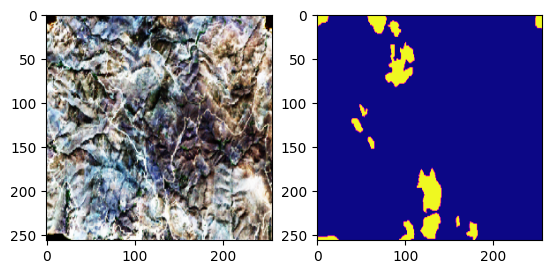

In [57]:
from matplotlib import pyplot as plt

# File for generator to visualize
tif_file = '/content/drive/MyDrive/newdatsset/Anafi_cube.tif'

# Initialize data generator that generate batch of 1 image.
sample_gen = DataGen(x_set=[tif_file], batch_size=1)
# Get first generated RGB image (x) and label mask (y)
x, y = sample_gen.__getitem__(0)

# Layer to visualize
layer = 16

x = x[0]
# Swap BGR to RGB - opencv style
x = x[:,:,::-1]
# Extract wanted mask layer to visualize
y = y[0][:,:,layer]

# Visualize it
fig, ax = plt.subplots(1,2)
ax[0].imshow(x, vmin=0, vmax=1)
ax[1].imshow(y, cmap='plasma')

### Run the Training

In [58]:
# Run the training
results = model.fit(train_gen, validation_data = val_gen, epochs = n_epochs)

# Save the trained model to a file
model.save('unet-eval.h5')

Epoch 1/20


1/7 [===>..........................] - ETA: 53s - loss: 0.6860 - accuracy: 0.0587

2/7 [=======>......................] - ETA: 1s - loss: 0.6702 - accuracy: 0.0670 

3/7 [===========>..................] - ETA: 2s - loss: 0.6566 - accuracy: 0.0767

4/7 [================>.............] - ETA: 2s - loss: 0.6453 - accuracy: 0.0879

5/7 [====================>.........] - ETA: 1s - loss: 0.6362 - accuracy: 0.0990

6/7 [========================>.....] - ETA: 0s - loss: 0.6296 - accuracy: 0.0872

7/7 [==============================] - ETA: 0s - loss: 0.6233 - accuracy: 0.0818

<ipython-input-52-145ca2531460>:37: RuntimeWarning: overflow encountered in true_divide
  r = tiff_img[16] ; r[np.isnan(r)]=0 ; r = (r/r.max())*255 ; r=cv.equalizeHist(r.astype('uint8')) ; r = r/255 ; r = np.expand_dims(r, axis=2)
<ipython-input-52-145ca2531460>:38: RuntimeWarning: overflow encountered in true_divide
  g = tiff_img[15] ; g[np.isnan(g)]=0 ; g = (g/g.max())*255 ; g=cv.equalizeHist(g.astype('uint8')) ; g = g/255 ; g = np.expand_dims(g, axis=2)
<ipython-input-52-145ca2531460>:39: RuntimeWarning: overflow encountered in true_divide
  b = tiff_img[14] ; b[np.isnan(b)]=0 ; b = (b/b.max())*255 ; b=cv.equalizeHist(b.astype('uint8')) ; b = b/255 ; b = np.expand_dims(b, axis=2)


7/7 [==============================] - 16s 1s/step - loss: 0.6233 - accuracy: 0.0818 - val_loss: 0.4766 - val_accuracy: 0.4359
Epoch 2/20


1/7 [===>..........................] - ETA: 4s - loss: 0.5567 - accuracy: 0.1639

2/7 [=======>......................] - ETA: 8s - loss: 0.5503 - accuracy: 0.1760

3/7 [===========>..................] - ETA: 4s - loss: 0.5478 - accuracy: 0.1503

4/7 [================>.............] - ETA: 3s - loss: 0.5423 - accuracy: 0.1570

5/7 [====================>.........] - ETA: 1s - loss: 0.5367 - accuracy: 0.1697

6/7 [========================>.....] - ETA: 0s - loss: 0.5339 - accuracy: 0.1521

7/7 [==============================] - ETA: 0s - loss: 0.5274 - accuracy: 0.1758

7/7 [==============================] - 7s 1s/step - loss: 0.5274 - accuracy: 0.1758 - val_loss: 0.4546 - val_accuracy: 0.1057
Epoch 3/20


1/7 [===>..........................] - ETA: 6s - loss: 0.4782 - accuracy: 0.3570

2/7 [=======>......................] - ETA: 2s - loss: 0.4811 - accuracy: 0.2522

3/7 [===========>..................] - ETA: 1s - loss: 0.4762 - accuracy: 0.2778

4/7 [================>.............] - ETA: 2s - loss: 0.4720 - accuracy: 0.2777

5/7 [====================>.........] - ETA: 1s - loss: 0.4665 - accuracy: 0.3025

6/7 [========================>.....] - ETA: 0s - loss: 0.4621 - accuracy: 0.3117

7/7 [==============================] - ETA: 0s - loss: 0.4606 - accuracy: 0.2873

7/7 [==============================] - 7s 935ms/step - loss: 0.4606 - accuracy: 0.2873 - val_loss: 0.3916 - val_accuracy: 0.1828
Epoch 4/20


1/7 [===>..........................] - ETA: 3s - loss: 0.4344 - accuracy: 0.2189

2/7 [=======>......................] - ETA: 0s - loss: 0.4249 - accuracy: 0.3233

3/7 [===========>..................] - ETA: 2s - loss: 0.4158 - accuracy: 0.4119

4/7 [================>.............] - ETA: 1s - loss: 0.4107 - accuracy: 0.4405

5/7 [====================>.........] - ETA: 1s - loss: 0.4069 - accuracy: 0.4479

6/7 [========================>.....] - ETA: 0s - loss: 0.4068 - accuracy: 0.4107

7/7 [==============================] - ETA: 0s - loss: 0.4037 - accuracy: 0.3966

7/7 [==============================] - 7s 1s/step - loss: 0.4037 - accuracy: 0.3966 - val_loss: 0.4387 - val_accuracy: 0.2058
Epoch 5/20


1/7 [===>..........................] - ETA: 7s - loss: 0.3578 - accuracy: 0.7006

2/7 [=======>......................] - ETA: 2s - loss: 0.3583 - accuracy: 0.6487

3/7 [===========>..................] - ETA: 1s - loss: 0.3582 - accuracy: 0.6008

4/7 [================>.............] - ETA: 1s - loss: 0.3619 - accuracy: 0.5246

5/7 [====================>.........] - ETA: 1s - loss: 0.3581 - accuracy: 0.5308

6/7 [========================>.....] - ETA: 0s - loss: 0.3590 - accuracy: 0.4878

7/7 [==============================] - ETA: 0s - loss: 0.3565 - accuracy: 0.4624

7/7 [==============================] - 8s 1s/step - loss: 0.3565 - accuracy: 0.4624 - val_loss: 0.4685 - val_accuracy: 0.6493
Epoch 6/20


1/7 [===>..........................] - ETA: 4s - loss: 0.3475 - accuracy: 0.2936

2/7 [=======>......................] - ETA: 2s - loss: 0.3337 - accuracy: 0.4270

3/7 [===========>..................] - ETA: 2s - loss: 0.3250 - accuracy: 0.5149

4/7 [================>.............] - ETA: 2s - loss: 0.3206 - accuracy: 0.5394

5/7 [====================>.........] - ETA: 1s - loss: 0.3198 - accuracy: 0.4931

6/7 [========================>.....] - ETA: 0s - loss: 0.3174 - accuracy: 0.4954

7/7 [==============================] - ETA: 0s - loss: 0.3183 - accuracy: 0.4782

7/7 [==============================] - 7s 1s/step - loss: 0.3183 - accuracy: 0.4782 - val_loss: 0.4692 - val_accuracy: 0.4479
Epoch 7/20


1/7 [===>..........................] - ETA: 7s - loss: 0.2756 - accuracy: 0.7509

2/7 [=======>......................] - ETA: 3s - loss: 0.2931 - accuracy: 0.5811

3/7 [===========>..................] - ETA: 1s - loss: 0.2895 - accuracy: 0.5609

4/7 [================>.............] - ETA: 1s - loss: 0.2857 - accuracy: 0.5726

5/7 [====================>.........] - ETA: 1s - loss: 0.2823 - accuracy: 0.5818

6/7 [========================>.....] - ETA: 0s - loss: 0.2819 - accuracy: 0.5355

7/7 [==============================] - ETA: 0s - loss: 0.2830 - accuracy: 0.5088

7/7 [==============================] - 7s 1s/step - loss: 0.2830 - accuracy: 0.5088 - val_loss: 0.4364 - val_accuracy: 0.6261
Epoch 8/20


1/7 [===>..........................] - ETA: 7s - loss: 0.2424 - accuracy: 0.7767

2/7 [=======>......................] - ETA: 3s - loss: 0.2625 - accuracy: 0.6288

3/7 [===========>..................] - ETA: 2s - loss: 0.2666 - accuracy: 0.5178

4/7 [================>.............] - ETA: 1s - loss: 0.2610 - accuracy: 0.5550

5/7 [====================>.........] - ETA: 0s - loss: 0.2584 - accuracy: 0.5565

6/7 [========================>.....] - ETA: 0s - loss: 0.2551 - accuracy: 0.5665

7/7 [==============================] - ETA: 0s - loss: 0.2547 - accuracy: 0.5299

7/7 [==============================] - 7s 933ms/step - loss: 0.2547 - accuracy: 0.5299 - val_loss: 0.5096 - val_accuracy: 0.5381
Epoch 9/20


1/7 [===>..........................] - ETA: 4s - loss: 0.2512 - accuracy: 0.3539

2/7 [=======>......................] - ETA: 11s - loss: 0.2469 - accuracy: 0.3393

3/7 [===========>..................] - ETA: 6s - loss: 0.2499 - accuracy: 0.3839 

4/7 [================>.............] - ETA: 4s - loss: 0.2401 - accuracy: 0.4684

5/7 [====================>.........] - ETA: 2s - loss: 0.2381 - accuracy: 0.4750

6/7 [========================>.....] - ETA: 0s - loss: 0.2338 - accuracy: 0.5023

7/7 [==============================] - ETA: 0s - loss: 0.2311 - accuracy: 0.5223

7/7 [==============================] - 7s 1s/step - loss: 0.2311 - accuracy: 0.5223 - val_loss: 0.4853 - val_accuracy: 0.5537
Epoch 10/20


1/7 [===>..........................] - ETA: 5s - loss: 0.2046 - accuracy: 0.6371

2/7 [=======>......................] - ETA: 0s - loss: 0.2078 - accuracy: 0.5969

3/7 [===========>..................] - ETA: 1s - loss: 0.2151 - accuracy: 0.5150

4/7 [================>.............] - ETA: 1s - loss: 0.2110 - accuracy: 0.5538

5/7 [====================>.........] - ETA: 1s - loss: 0.2048 - accuracy: 0.6049

6/7 [========================>.....] - ETA: 0s - loss: 0.2102 - accuracy: 0.5675

7/7 [==============================] - ETA: 0s - loss: 0.2110 - accuracy: 0.5304

7/7 [==============================] - 7s 1s/step - loss: 0.2110 - accuracy: 0.5304 - val_loss: 0.5154 - val_accuracy: 0.4611
Epoch 11/20


1/7 [===>..........................] - ETA: 2s - loss: 0.1964 - accuracy: 0.5635

2/7 [=======>......................] - ETA: 3s - loss: 0.1921 - accuracy: 0.5955

3/7 [===========>..................] - ETA: 4s - loss: 0.1956 - accuracy: 0.5027

4/7 [================>.............] - ETA: 2s - loss: 0.1992 - accuracy: 0.4727

5/7 [====================>.........] - ETA: 1s - loss: 0.1956 - accuracy: 0.4973

6/7 [========================>.....] - ETA: 0s - loss: 0.1999 - accuracy: 0.4927

7/7 [==============================] - ETA: 0s - loss: 0.1950 - accuracy: 0.5334

7/7 [==============================] - 7s 1s/step - loss: 0.1950 - accuracy: 0.5334 - val_loss: 0.6535 - val_accuracy: 0.5988
Epoch 12/20


1/7 [===>..........................] - ETA: 5s - loss: 0.1724 - accuracy: 0.6594

2/7 [=======>......................] - ETA: 0s - loss: 0.1750 - accuracy: 0.6146

3/7 [===========>..................] - ETA: 1s - loss: 0.1814 - accuracy: 0.5339

4/7 [================>.............] - ETA: 1s - loss: 0.1739 - accuracy: 0.6045

5/7 [====================>.........] - ETA: 1s - loss: 0.1767 - accuracy: 0.5497

6/7 [========================>.....] - ETA: 0s - loss: 0.1749 - accuracy: 0.5739

7/7 [==============================] - ETA: 0s - loss: 0.1801 - accuracy: 0.5475

7/7 [==============================] - 7s 1s/step - loss: 0.1801 - accuracy: 0.5475 - val_loss: 0.4465 - val_accuracy: 0.5605
Epoch 13/20


1/7 [===>..........................] - ETA: 5s - loss: 0.1597 - accuracy: 0.6520

2/7 [=======>......................] - ETA: 8s - loss: 0.1692 - accuracy: 0.5246

3/7 [===========>..................] - ETA: 5s - loss: 0.1806 - accuracy: 0.4879

4/7 [================>.............] - ETA: 3s - loss: 0.1796 - accuracy: 0.4639

5/7 [====================>.........] - ETA: 1s - loss: 0.1764 - accuracy: 0.4870

6/7 [========================>.....] - ETA: 0s - loss: 0.1740 - accuracy: 0.5049

7/7 [==============================] - ETA: 0s - loss: 0.1696 - accuracy: 0.5407

7/7 [==============================] - 8s 1s/step - loss: 0.1696 - accuracy: 0.5407 - val_loss: 0.4458 - val_accuracy: 0.4491
Epoch 14/20


1/7 [===>..........................] - ETA: 5s - loss: 0.1937 - accuracy: 0.3777

2/7 [=======>......................] - ETA: 8s - loss: 0.1816 - accuracy: 0.3919

3/7 [===========>..................] - ETA: 4s - loss: 0.1711 - accuracy: 0.4866

4/7 [================>.............] - ETA: 2s - loss: 0.1667 - accuracy: 0.5110

5/7 [====================>.........] - ETA: 1s - loss: 0.1670 - accuracy: 0.4975

6/7 [========================>.....] - ETA: 0s - loss: 0.1642 - accuracy: 0.5206

7/7 [==============================] - ETA: 0s - loss: 0.1596 - accuracy: 0.5584

7/7 [==============================] - 7s 991ms/step - loss: 0.1596 - accuracy: 0.5584 - val_loss: 0.4036 - val_accuracy: 0.6013
Epoch 15/20


1/7 [===>..........................] - ETA: 3s - loss: 0.1613 - accuracy: 0.4166

2/7 [=======>......................] - ETA: 4s - loss: 0.1762 - accuracy: 0.4143

3/7 [===========>..................] - ETA: 6s - loss: 0.1734 - accuracy: 0.4111

4/7 [================>.............] - ETA: 4s - loss: 0.1617 - accuracy: 0.5133

5/7 [====================>.........] - ETA: 2s - loss: 0.1595 - accuracy: 0.5317

6/7 [========================>.....] - ETA: 1s - loss: 0.1564 - accuracy: 0.5553

7/7 [==============================] - ETA: 0s - loss: 0.1545 - accuracy: 0.5715

7/7 [==============================] - 8s 1s/step - loss: 0.1545 - accuracy: 0.5715 - val_loss: 0.3171 - val_accuracy: 0.5294
Epoch 16/20


1/7 [===>..........................] - ETA: 6s - loss: 0.1873 - accuracy: 0.3387

2/7 [=======>......................] - ETA: 0s - loss: 0.1650 - accuracy: 0.4566

3/7 [===========>..................] - ETA: 2s - loss: 0.1516 - accuracy: 0.5584

4/7 [================>.............] - ETA: 1s - loss: 0.1478 - accuracy: 0.5807

5/7 [====================>.........] - ETA: 1s - loss: 0.1501 - accuracy: 0.5371

6/7 [========================>.....] - ETA: 0s - loss: 0.1521 - accuracy: 0.5198

7/7 [==============================] - ETA: 0s - loss: 0.1502 - accuracy: 0.5406

7/7 [==============================] - 8s 1s/step - loss: 0.1502 - accuracy: 0.5406 - val_loss: 0.3510 - val_accuracy: 0.5292
Epoch 17/20


1/7 [===>..........................] - ETA: 11s - loss: 0.1526 - accuracy: 0.4253

2/7 [=======>......................] - ETA: 2s - loss: 0.1421 - accuracy: 0.5516 

3/7 [===========>..................] - ETA: 2s - loss: 0.1556 - accuracy: 0.5112

4/7 [================>.............] - ETA: 1s - loss: 0.1535 - accuracy: 0.4867

5/7 [====================>.........] - ETA: 1s - loss: 0.1497 - accuracy: 0.5240

6/7 [========================>.....] - ETA: 0s - loss: 0.1471 - accuracy: 0.5399

7/7 [==============================] - ETA: 0s - loss: 0.1423 - accuracy: 0.5811

7/7 [==============================] - 7s 837ms/step - loss: 0.1423 - accuracy: 0.5811 - val_loss: 0.2944 - val_accuracy: 0.5494
Epoch 18/20


1/7 [===>..........................] - ETA: 5s - loss: 0.1261 - accuracy: 0.7182

2/7 [=======>......................] - ETA: 5s - loss: 0.1173 - accuracy: 0.7808

3/7 [===========>..................] - ETA: 3s - loss: 0.1246 - accuracy: 0.6801

4/7 [================>.............] - ETA: 3s - loss: 0.1310 - accuracy: 0.6107

5/7 [====================>.........] - ETA: 2s - loss: 0.1308 - accuracy: 0.6331

7/7 [==============================] - ETA: 0s - loss: 0.1381 - accuracy: 0.5971

7/7 [==============================] - 8s 1s/step - loss: 0.1381 - accuracy: 0.5971 - val_loss: 0.2306 - val_accuracy: 0.5283
Epoch 19/20


1/7 [===>..........................] - ETA: 5s - loss: 0.1781 - accuracy: 0.3877

2/7 [=======>......................] - ETA: 2s - loss: 0.1541 - accuracy: 0.5275

3/7 [===========>..................] - ETA: 1s - loss: 0.1453 - accuracy: 0.5626

4/7 [================>.............] - ETA: 1s - loss: 0.1370 - accuracy: 0.6146

5/7 [====================>.........] - ETA: 1s - loss: 0.1383 - accuracy: 0.5874

6/7 [========================>.....] - ETA: 0s - loss: 0.1352 - accuracy: 0.6030

7/7 [==============================] - ETA: 0s - loss: 0.1341 - accuracy: 0.6129

7/7 [==============================] - 7s 989ms/step - loss: 0.1341 - accuracy: 0.6129 - val_loss: 0.2091 - val_accuracy: 0.4778
Epoch 20/20


1/7 [===>..........................] - ETA: 11s - loss: 0.1369 - accuracy: 0.4770

2/7 [=======>......................] - ETA: 5s - loss: 0.1207 - accuracy: 0.6606 

3/7 [===========>..................] - ETA: 3s - loss: 0.1212 - accuracy: 0.6815

4/7 [================>.............] - ETA: 2s - loss: 0.1246 - accuracy: 0.6215

5/7 [====================>.........] - ETA: 1s - loss: 0.1342 - accuracy: 0.5800

6/7 [========================>.....] - ETA: 0s - loss: 0.1316 - accuracy: 0.5927

7/7 [==============================] - ETA: 0s - loss: 0.1301 - accuracy: 0.6018

7/7 [==============================] - 7s 857ms/step - loss: 0.1301 - accuracy: 0.6018 - val_loss: 0.2695 - val_accuracy: 0.4587


### Prediction Test with Sample Image from Dataset

In [59]:
from tensorflow.keras import models
from matplotlib import pyplot as plt

# Load test image
test_img_path = '/content/drive/MyDrive/newdatsset/Anafi_cube.tif'

# Open tiff file
tiff_file = rasterio.open(test_img_path) 
# Read all layers
tiff_img = tiff_file.read()
# Get R, G, B components from layer 16, 15, 14 respectively. Make element with 'nan' to 0, scale to [0-255], equalize histogram to enhance contrast.
# Rescale back to [0-1], expand the dimension on axis-2 (for example to make shape from (256, 256) to become (256, 256, 1))
r = tiff_img[16] ; r[np.isnan(r)]=0 ; r = (r/r.max())*255 ; r=cv.equalizeHist(r.astype('uint8')) ; r = r/255 ; r = np.expand_dims(r, axis=2)
g = tiff_img[15] ; g[np.isnan(g)]=0 ; g = (g/g.max())*255 ; g=cv.equalizeHist(g.astype('uint8')) ; g = g/255 ; g = np.expand_dims(g, axis=2)
b = tiff_img[14] ; b[np.isnan(b)]=0 ; b = (b/b.max())*255 ; b=cv.equalizeHist(b.astype('uint8')) ; b = b/255 ; b = np.expand_dims(b, axis=2)
# Concat R, G, B array in depth axes 
rgb_img = np.concatenate([r, g, b], 2)
# Resize the array WxH to 256x256 to match the input size of U-Net
rgb_img = cv.resize(rgb_img, (256,256))
rgb_img = np.reshape(rgb_img,(1,256,256,3))

# Load trained model
model_name = 'unet-eval.h5'
model = models.load_model(model_name)

# Perform Prediction
preds = model.predict(rgb_img, verbose=1)

print (preds.shape)

1/1 [==============================] - 0s 325ms/step
(1, 256, 256, 18)


### Show Prediciton Result

IOU: 0.06975959510754956


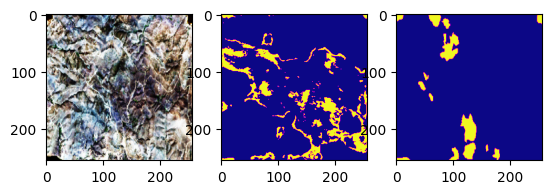

In [60]:
from matplotlib import pyplot as plt

# Layer to visualize
layer = 16

# Extract channel
pred = (preds[0])
_, pred = cv.threshold(pred, 0.2, 1, cv.THRESH_BINARY)

# Show
fig, ax = plt.subplots(1,3)
# Input Image
ax[0].imshow(rgb_img[0][:,:,::-1], vmin=0, vmax=1)
# Prediction Result
ax[1].imshow(pred[:,:,layer], cmap='plasma')

# Ground Truth
n_class = 18
mask = tiff_img[24]
mask[mask==-999] = 16
mask[mask==-100] = 17
encoded = np.zeros((mask.shape[0], mask.shape[1], 18))
for i in range(n_class):
  encoded[:,:,i] = mask==i
gt = encoded[:,:,layer]
gt = cv.resize(gt, (256,256))
ax[2].imshow(gt, cmap='plasma')

# IOU
intersection = np.logical_and(pred[:,:,layer], gt)
union = np.logical_or(pred[:,:,layer], gt)
iou = np.sum(intersection) / np.sum(union)

print (f'IOU: {iou}')

IOU: 0.06767884714359239
Precision: 0.09287816362566216
Recall: 0.19964574898785425
F1 Score: 0.1267775367558448


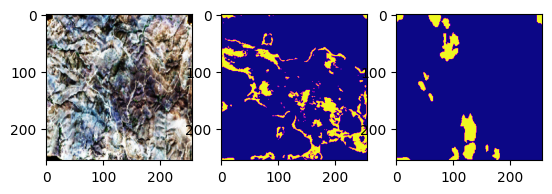

In [61]:
from matplotlib import pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

# Layer to visualize
layer = 16

# Extract channel
pred = (preds[0])
_, pred = cv.threshold(pred, 0.2, 1, cv.THRESH_BINARY)

# Show
fig, ax = plt.subplots(1,3)
# Input Image
ax[0].imshow(rgb_img[0][:,:,::-1], vmin=0, vmax=1)
# Prediction Result
ax[1].imshow(pred[:,:,layer], cmap='plasma')

# Ground Truth
n_class = 18
mask = tiff_img[24]
mask[mask==-999] = 16
mask[mask==-100] = 17
encoded = np.zeros((mask.shape[0], mask.shape[1], 18))
for i in range(n_class):
  encoded[:,:,i] = mask==i
gt = encoded[:,:,layer]
gt = cv.resize(gt, (256,256))

# Threshold Ground Truth to create binary mask
_, gt = cv.threshold(gt, 0.2, 1, cv.THRESH_BINARY)
ax[2].imshow(gt, cmap='plasma')

# IOU
intersection = np.logical_and(pred[:,:,layer], gt)
union = np.logical_or(pred[:,:,layer], gt)
iou = np.sum(intersection) / np.sum(union)

print (f'IOU: {iou}')

# Flatten prediction and ground truth for metric calculations
pred_flat = pred[:,:,layer].flatten()
gt_flat = gt.flatten()

# Precision, Recall and F1 Score
precision = precision_score(gt_flat, pred_flat)
recall = recall_score(gt_flat, pred_flat)
f1 = f1_score(gt_flat, pred_flat)

# Print out the Precision, Recall, and F1 Score
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')



### Visualize Ground Truth
Visualize the ground truth (specific mask layer) from a file 

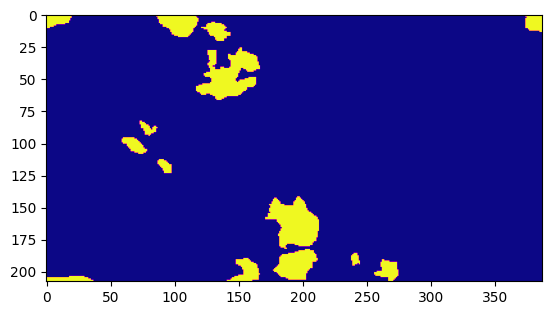

In [62]:
from matplotlib import pyplot as plt

# Load test image
test_img_path = '/content/drive/MyDrive/newdatsset/Anafi_cube.tif'

# Label layer to visualize
label_id = 16

def hot_encode_label(tiff_path, n_class, label_channel=25):
  # Hot encode the label from 1 layer array to 18 layer array and return array with 1 selected layer
  tiff_file = rasterio.open(tiff_path) 
  mask = tiff_file.read(25)
  mask[mask==-999] = 16
  mask[mask==-100] = 17
  encoded = np.zeros((mask.shape[0], mask.shape[1], 18))
  for i in range(n_class):
    encoded[:,:,i] = mask==i

  return encoded

labels = hot_encode_label (test_img_path, n_class = 18)
label = labels[:,:,label_id]

# Threshold it to produce binary image
_, label = cv.threshold(label, 0.5, 1, cv.THRESH_BINARY)

plt.imshow(label, cmap = 'plasma')
